In [104]:
import csv
import random
import numpy as np
import sklearn as sk
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import impute
from sklearn import feature_selection
from sklearn import tree
from sklearn import neural_network
from sklearn import cluster
from copy import deepcopy
import seaborn as sns

def loadFile(filePath):
    dataset = []
    with open(filePath, 'r') as fd:
        header = next(fd)
        reader = csv.reader(fd, delimiter=';')
        for row in reader:
            for i in range(len(row)):
                row[i] = float(row[i])
            dataset.append(row)
    return dataset, header.replace('"', '').split(';')

def createDataFrame(dataset, header):
    df = pd.DataFrame(dataset, columns = header)
    df["wine classification"] =  ["good" if i >= 7 else ("bad" if i < 5 else "medium") for i in df['quality']]
    df = df.drop("quality", axis=1)
    X = df.drop("wine classification", axis=1)
    return df, X

def removeValues(dataset, percentage):
    copy = deepcopy(dataset)
    toRemove = int(len(dataset[0])*percentage)
    print(len(dataset), percentage, toRemove)
    for row in copy:
        for i in range(toRemove):
            feature = int(random.random() * len(row)) 
            row[feature] = np.nan
    return copy

def handleMissingValues(dataset, strat):
    imp = sk.impute.SimpleImputer(missing_values=np.nan, strategy=strat)
    return imp.fit_transform(dataset)

def applyNormalization(dataset, norm):
    copy = deepcopy(dataset)
    return sk.preprocessing.normalize(copy, norm=norm)

def applyDiscretization(dataset):
    copy = deepcopy(dataset)
    transf = sk.preprocessing.KBinsDiscretizer(n_bins = 3, encode = 'ordinal', strategy = 'quantile')
    return transf.fit_transform(copy)

def applyDataReduction(dataset):
    copy = deepcopy(dataset)
    agglo = sk.cluster.FeatureAgglomeration(n_clusters=5)
    return agglo.fit_transform(copy)

def pearsonCorrelation(dataset, header, target):
    dictPearson = {}
    df = pd.DataFrame(dataset, columns = header)
    y = df[target]          #Target Variable
    X = df.drop(target, axis=1)   #Feature Matrix
    pearson = sk.feature_selection.r_regression(X, y, center=True)
    return pearson

def plotPearson(dataset, header, target, colors):
    pearson = pearsonCorrelation(dataset, header, target)
    headerPearson = deepcopy(header)
    headerPearson.remove(target)
    plt.title('Target Feature: ' + target)
    plt.barh(headerPearson, pearson, height=0.8, align='center', tick_label=headerPearson,
             color=colors)
    plt.xlim([-1,1])
    plt.show()

def plotAllPearson(dataset, header):
    colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(11)]
    for target in header:
        plotPearson(dataset, header, target, colors)
    
def randomColors(n):
    colors = []
    for i in range(n):
        colors.append(np.random.choice(range(256), size=3))
    print(colors)
    return colors

def correlationMatrix(df, title):
    corr_mat = df.corr()
    plt.figure(figsize=(13,5))
    plt.title(title)
    sns_plot = sns.heatmap(data=corr_mat, annot=True, cmap='GnBu')
    plt.show()
    
def barPlotWineQuality(red, white):
    orderedListRed = []
    orderedListRed.append(red["wine classification"].value_counts()[2])
    orderedListRed.append(red["wine classification"].value_counts()[0])
    orderedListRed.append(red["wine classification"].value_counts()[1])
    
    orderedListWhite = []
    orderedListWhite.append(white["wine classification"].value_counts()[2])
    orderedListWhite.append(white["wine classification"].value_counts()[0])
    orderedListWhite.append(white["wine classification"].value_counts()[1])

    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    
    
    ax1.bar(x=['bad', 'medium', 'good'], height=orderedListRed)
    ax2.bar(x=['bad', 'medium', 'good'], height=orderedListWhite)
    
def visualizePairOfFeatures(df, xfeature, yfeature):
    sns.set(color_codes=True)
    g = sns.lmplot(x=xfeature, y=yfeature, data=df, line_kws={'color': 'limegreen'})
    
def decisionTree(df, X, target, header):
    y = df[target]          #Target Variable
    clf = tree.DecisionTreeClassifier(splitter='best', max_features = 11, random_state = 1)
    clf = clf.fit(X, y)
    tree.export_graphviz(clf, out_file='tree.dot', feature_names=header[:-1], class_names=["bad","good","medium"]) 
    plt.figure(figsize=(20, 20))
    tree.plot_tree(clf, feature_names=header, class_names=["bad","good","medium"])
    #ainda só está a criar a arvore, falta por a fazer a classificação
    
def ourMLPClassifier(df, X, target):
    y = df[target]
    X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, stratify=y, random_state=1)
    clf = sk.neural_network.MLPClassifier(random_state=1, max_iter=10000).fit(X_train, y_train)
    # caso queiramos ver os resultados, dar return ao predict
    clf.predict(X_test)
    return clf.score(X_test, y_test)

def knn(df, X, target):
    knn = sk.neighbors.KNeighborsClassifier(n_neighbors=7)
    y = df[target]
    X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, stratify=y, random_state=1)
    knn.fit(X_train, y_train)

    #Predict the response for test dataset
    
    y_pred= knn.predict(X_test)
    return knn.score(X_test, y_test)
    
def kMeans(df, X, target, header):
    y = df[target]
    X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, stratify=y, random_state=1)
    clf = sk.cluster.KMeans(n_clusters=3, random_state=1).fit(X_train, y_train)
    # caso queiramos ver os resultados, dar return ao predict
    y_pred = clf.predict(X_test)
    return clf.score(X_test)

def dbscan(df, X, target):
    y = df[target]
    neigh = sk.neighbors.NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)
    
    clf = sk.cluster.DBSCAN(eps=3, min_samples=3).fit_predict(X, y)
    # caso queiramos ver os resultados, dar return ao predict
    #clf.predict(X_test)
    return clf[:500]

def agglomerativeClustering(df, X, target):
    y = df[target]
    clf = sk.cluster.AgglomerativeClustering(n_clusters = 2).fit_predict(X, y)
    # caso queiramos ver os resultados, dar return ao predict
    #clf.predict(X_test)
    return clf[:500]
    



## Load Datasets

In [70]:
#Loading Datasets
redWineData, headerRed = loadFile("./winequality-red.csv")
headerRed[11] = headerRed[11].strip('\n')

whiteWineData, headerWhite = loadFile("./winequality-white.csv")
headerWhite[11] = headerWhite[11].strip('\n')

## Remove Values (Add missing values)

In [71]:
redMissing10per = removeValues(redWineData, 0.1)
redMissing20per = removeValues(redWineData, 0.2)
redMissing30per = removeValues(redWineData, 0.3)

whiteMissing10per = removeValues(whiteWineData, 0.1)
whiteMissing20per = removeValues(whiteWineData, 0.2)
whiteMissing30per = removeValues(whiteWineData, 0.3)

1599 0.1 1
1599 0.2 2
1599 0.3 3
4898 0.1 1
4898 0.2 2
4898 0.3 3


## Handle Missing Values

In [72]:
redMean10 = handleMissingValues(redMissing10per, 'mean')
redMean20 = handleMissingValues(redMissing20per, 'mean')
redMean30 = handleMissingValues(redMissing30per, 'mean')

whiteMostFreq10 = handleMissingValues(whiteMissing10per, 'most_frequent')
whiteMostFreq20 = handleMissingValues(whiteMissing20per, 'most_frequent')
whiteMostFreq30 = handleMissingValues(whiteMissing30per, 'most_frequent')

## Convert To Dataframe

In [73]:
redDF, rX = createDataFrame(redWineData, headerRed)

whiteDF, wX = createDataFrame(whiteWineData, headerWhite)

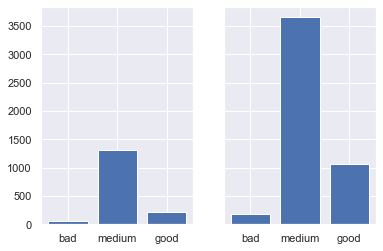

In [74]:
barPlotWineQuality(redDF, whiteDF)

## Normalizing Values

In [75]:
redNorm1 = applyNormalization(rX, 'l1')
redNorm2 = applyNormalization(rX, 'l2')
redNormMax = applyNormalization(rX, 'max')

whiteNorm1 = applyNormalization(wX, 'l1')
whiteNorm2 = applyNormalization(wX, 'l2')
whiteNormMax = applyNormalization(wX, 'max')

## Data Reduction

In [76]:
redReduct = applyDataReduction(rX)

whiteReduct = applyDataReduction(wX)

## Data Discretization

In [77]:
redDiscret = applyDiscretization(rX)

whiteDiscret = applyDiscretization(wX)

# Destacar graficos com alta correlação
## Pairplot of Red Wine Dataset

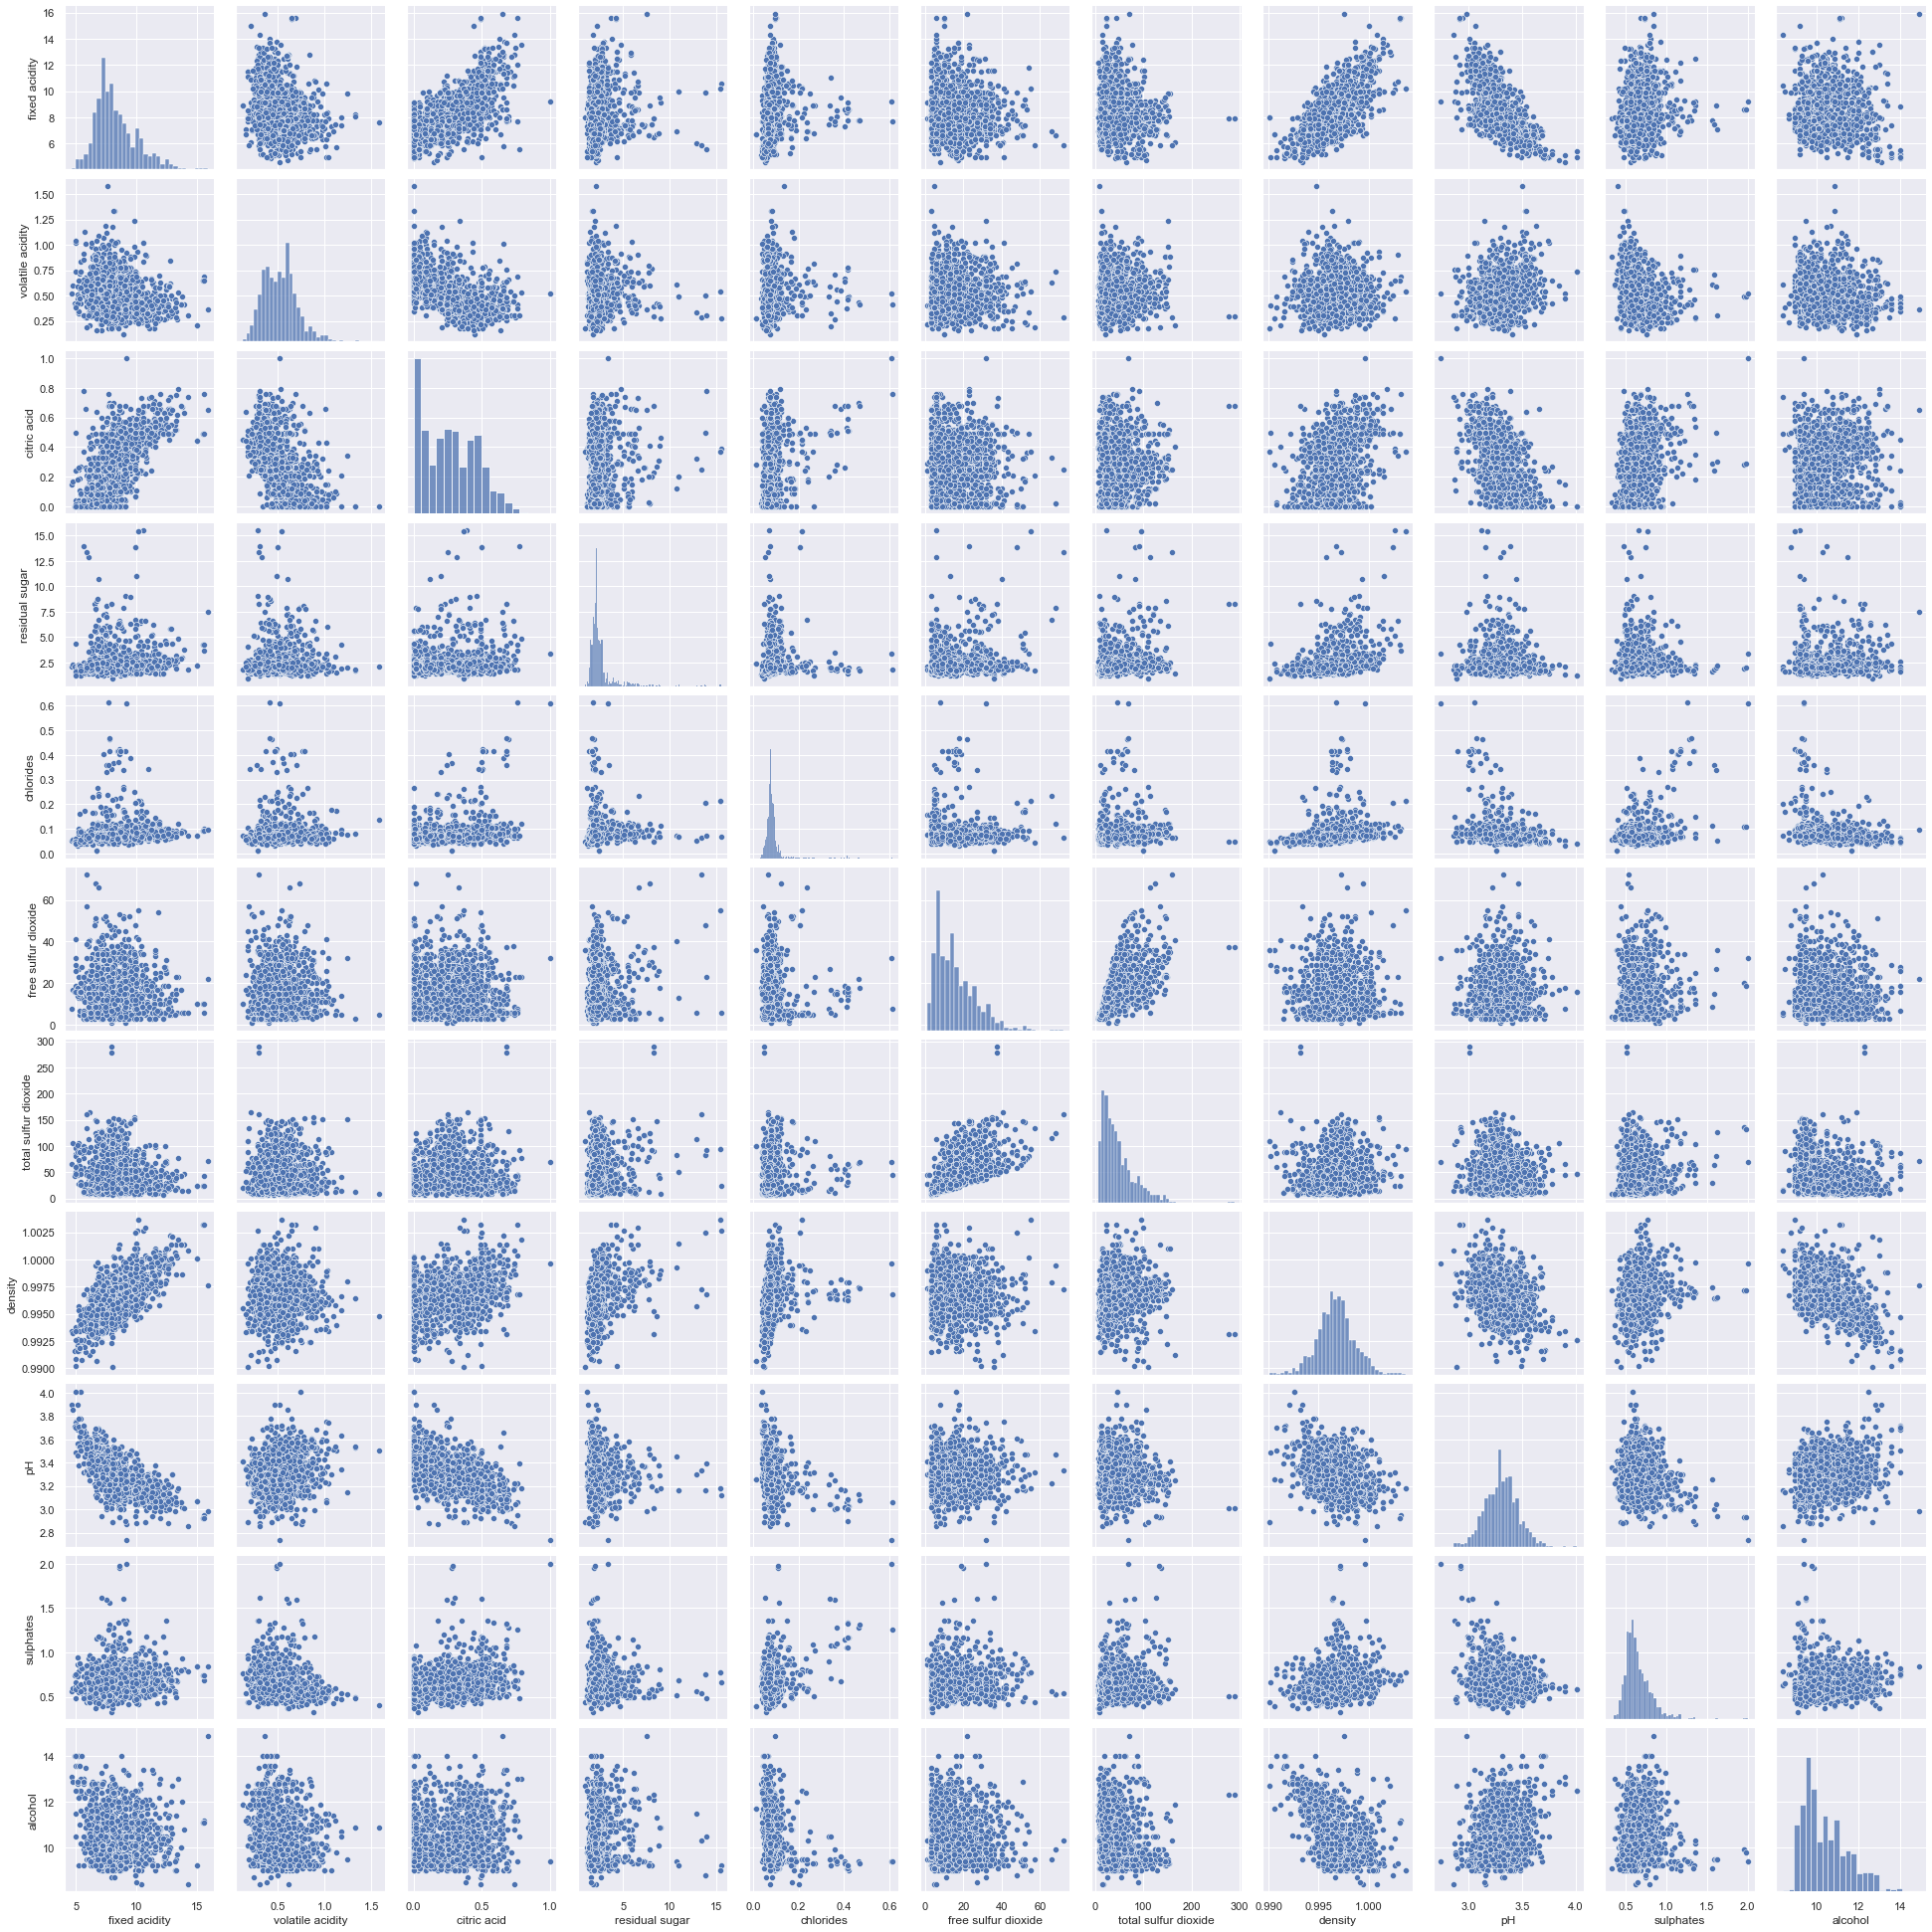

In [78]:
sns_visualization = sns.pairplot(redDF)

## Pairplot of White Wine Dataset

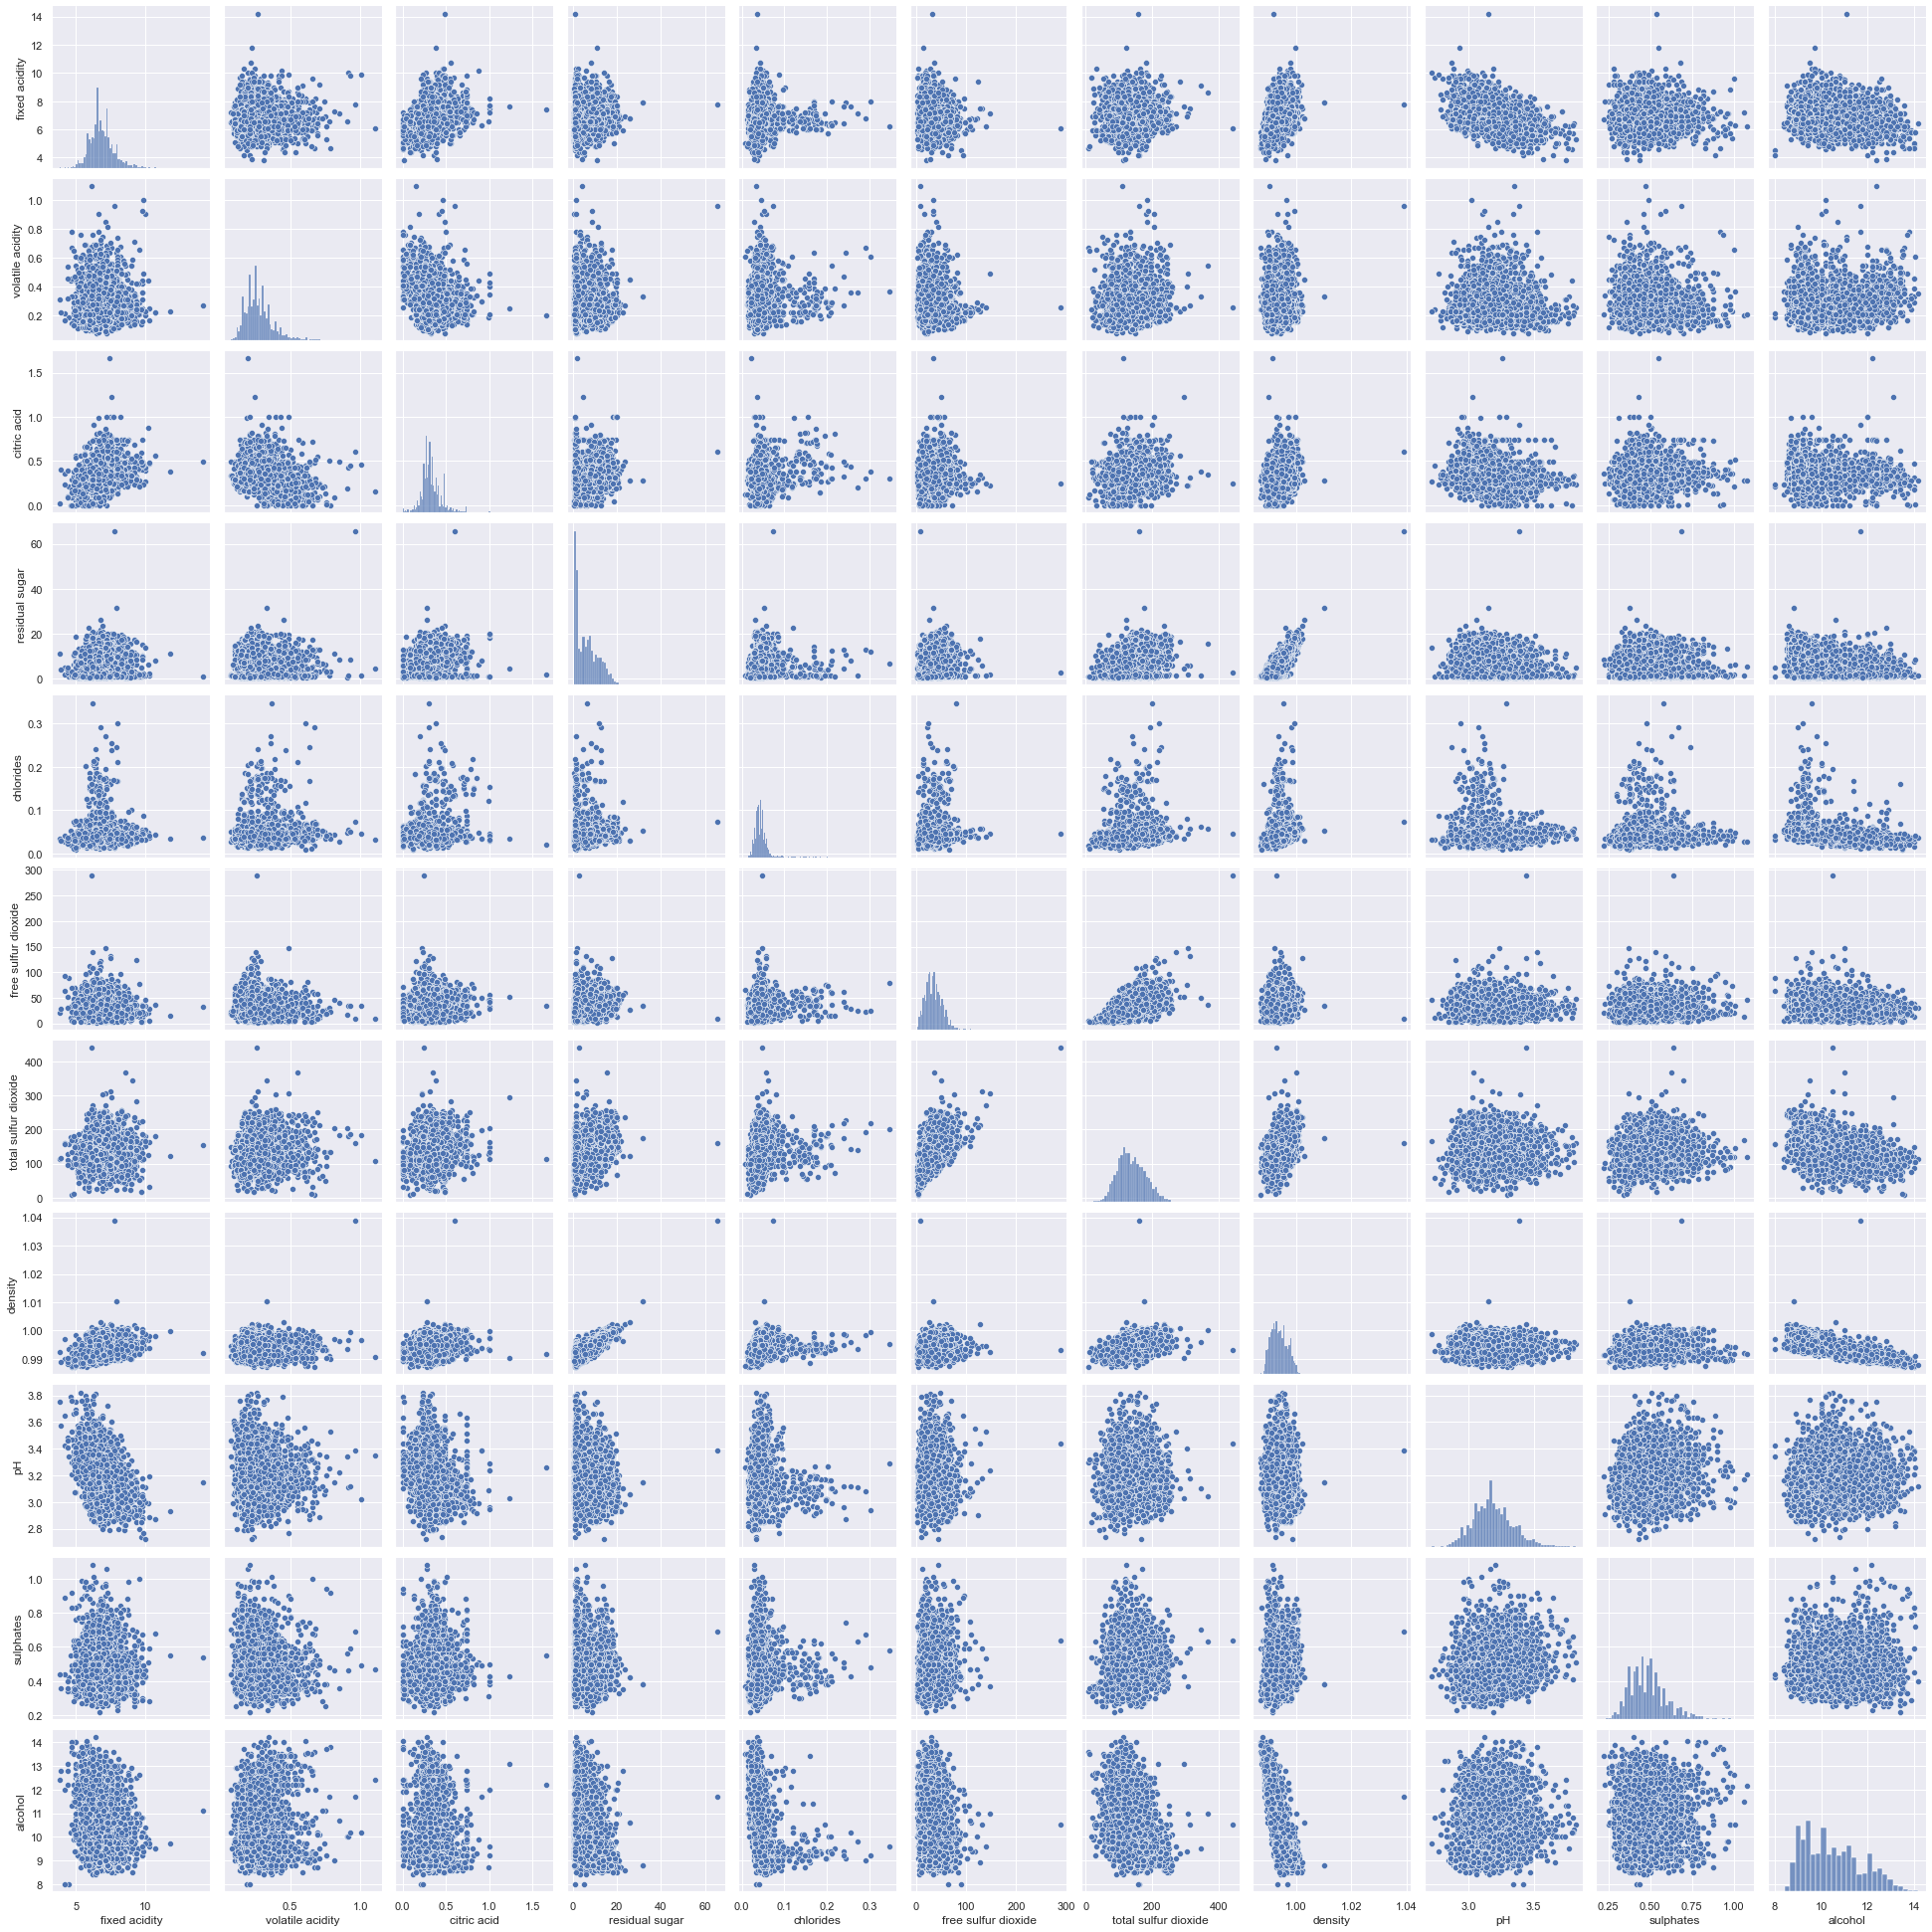

In [79]:
sns_visualization = sns.pairplot(whiteDF)

## Correlation Matrix

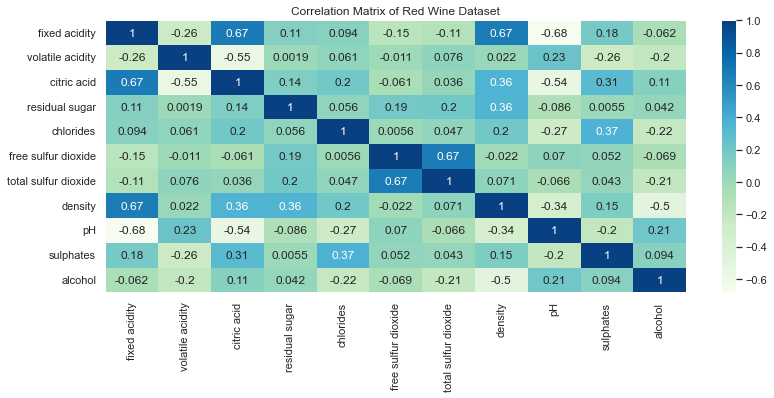

In [80]:
correlationMatrix(redDF, "Correlation Matrix of Red Wine Dataset")

correlationMatrix(whiteDF, "Correlation Matrix of White Wine Dataset")

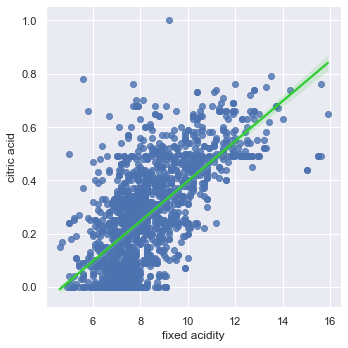

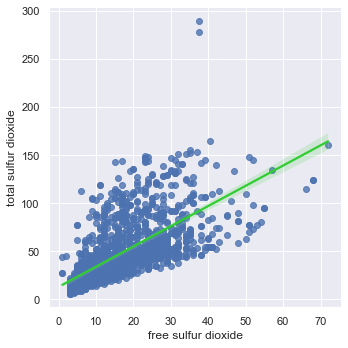

In [81]:
visualizePairOfFeatures(redDF, "fixed acidity", "citric acid")
visualizePairOfFeatures(redDF, "fixed acidity", "density")
visualizePairOfFeatures(redDF, "free sulfur dioxide", "total sulfur dioxide")

# Supervised Learning Algorithms

## Decision Tree of Red Wine Dataset

In [82]:
decisionTree(redDF, rX, "wine classification", headerRed)

## Decision Tree of White Wine Dataset (Alterar o nome do ficheiro consoante o dataset)

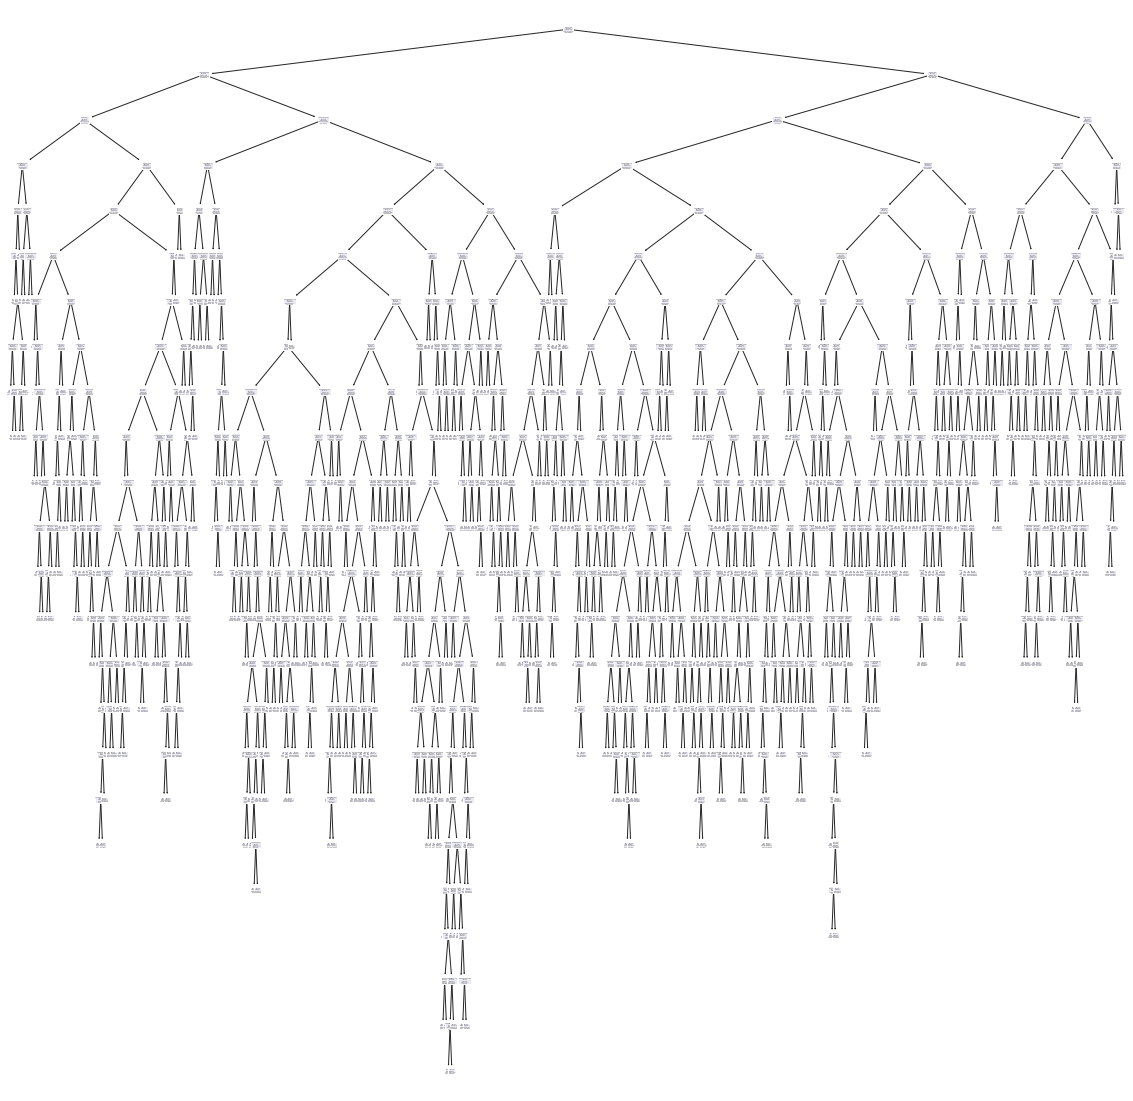

In [83]:
decisionTree(whiteDF, wX, "wine classification", headerWhite)

## Multi-Layer Perceptron Algorithm

In [84]:
redMLP = ourMLPClassifier(redDF, rX, "wine classification")
whiteMLP = ourMLPClassifier(whiteDF, wX, "wine classification")

print("Score for the Red Dataset:", redMLP)
print("Score for the White Dataset:", whiteMLP)

Score for the Red Dataset 0.84
Score for the White Dataset 0.7387755102040816


## k-NN Algorithm

In [105]:
redKnn = knn(redDF, rX, "wine classification")
whiteKnn = knn(whiteDF, wX, "wine classification")

print("Score for the Red Dataset:", redKnn)
print("Score for the White Dataset:", whiteKnn)

Score for the Red Dataset: 0.8175
Score for the White Dataset: 0.7453061224489796


# Unsupervised Learning Algorithms

## k-Means Algorithm

In [102]:
redKMeans = kMeans(redDF, rX, "wine classification", headerRed)
whiteKMeans = kMeans(whiteDF, wX, "wine classification", headerWhite)

print("Score for the Red Dataset:", redKMeans)
print("Score for the White Dataset:", whiteKMeans)

Score for the Red Dataset: -109631.17832092421
Score for the White Dataset: -660939.930152653


## DBScan Algorithm

In [106]:
dbscan(redDF, rX, "wine classification")

dbscan(whiteDF, wX, "wine classification")

array([  0,   1,   1,   1,   1,   1,   1,   0,   1,   1,   1,   1,   1,
        -1,  -1,   1,   1,   1,  -1,   1,   1,   1,   1,   2,   3,  -1,
         1,   1,   1,   1,  -1,   4,   1,   1,  -1,   1,   3,   1,  -1,
        -1,   5,   5,   1,   1,   1,   6,  -1,  -1,   1,   1,   7,   1,
         1,   1,   1,  -1,  -1,   1,   1,   1,   1,   1,   8,   1,   1,
         1,   1,  -1,   1,   9,  -1,  -1,  -1,   1,   1,   9,   1,   1,
         1,   1,   1,  51,   1,  -1,   1,   1,   1,  -1,   1,   1,   1,
        10,   1,   1,  11,  -1,  12,   1,  -1,  12,   1,  13,  -1,   0,
         1,  -1,  13,  14,  14,  68,  13,  -1,  -1,   1,   1,  -1,   3,
         1,  -1,  15,   1,  16,   1,  -1,   1,  82,  -1,  17,  18,  18,
        -1,  17,  -1,  -1,  19,  -1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,  -1,  -1,   1,   1,   1,  20,   1,   1,  -1,  21,
        21,   1,   1,   1,   1,  22,   1,  21,  23,  -1,  -1,   1,  -1,
        -1,   1,   1,  -1,   1,  -1,   1,  -1,  24,   1,   1,   

## Agglomerative Hierarchical Clustering Algorithm

In [108]:
agglomerativeClustering(redDF, rX, "wine classification")
agglomerativeClustering(whiteDF, wX, "wine classification")

array([1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,

['medium' 'good' 'medium' 'medium' 'good' 'medium' 'medium' 'medium'
 'medium' 'medium' 'medium' 'medium' 'medium' 'medium' 'medium' 'medium'
 'medium' 'good' 'medium' 'medium' 'medium' 'medium' 'medium' 'medium'
 'medium' 'medium' 'medium' 'medium' 'medium' 'medium' 'medium' 'medium'
 'good' 'good' 'medium' 'medium' 'medium' 'medium' 'medium' 'medium'
 'medium' 'medium' 'medium' 'medium' 'medium' 'medium' 'medium' 'medium'
 'medium' 'medium' 'medium' 'medium' 'medium' 'medium' 'medium' 'medium'
 'medium' 'medium' 'medium' 'medium' 'medium' 'medium' 'medium' 'medium'
 'medium' 'medium' 'medium' 'medium' 'medium' 'medium' 'medium' 'medium'
 'medium' 'medium' 'medium' 'good' 'medium' 'medium' 'medium' 'medium'
 'medium' 'medium' 'medium' 'medium' 'medium' 'medium' 'medium' 'medium'
 'medium' 'good' 'medium' 'medium' 'medium' 'medium' 'medium' 'medium'
 'medium' 'medium' 'medium' 'medium' 'medium' 'good' 'medium' 'medium'
 'medium' 'medium' 'medium' 'medium' 'good' 'medium' 'medium' 'medi

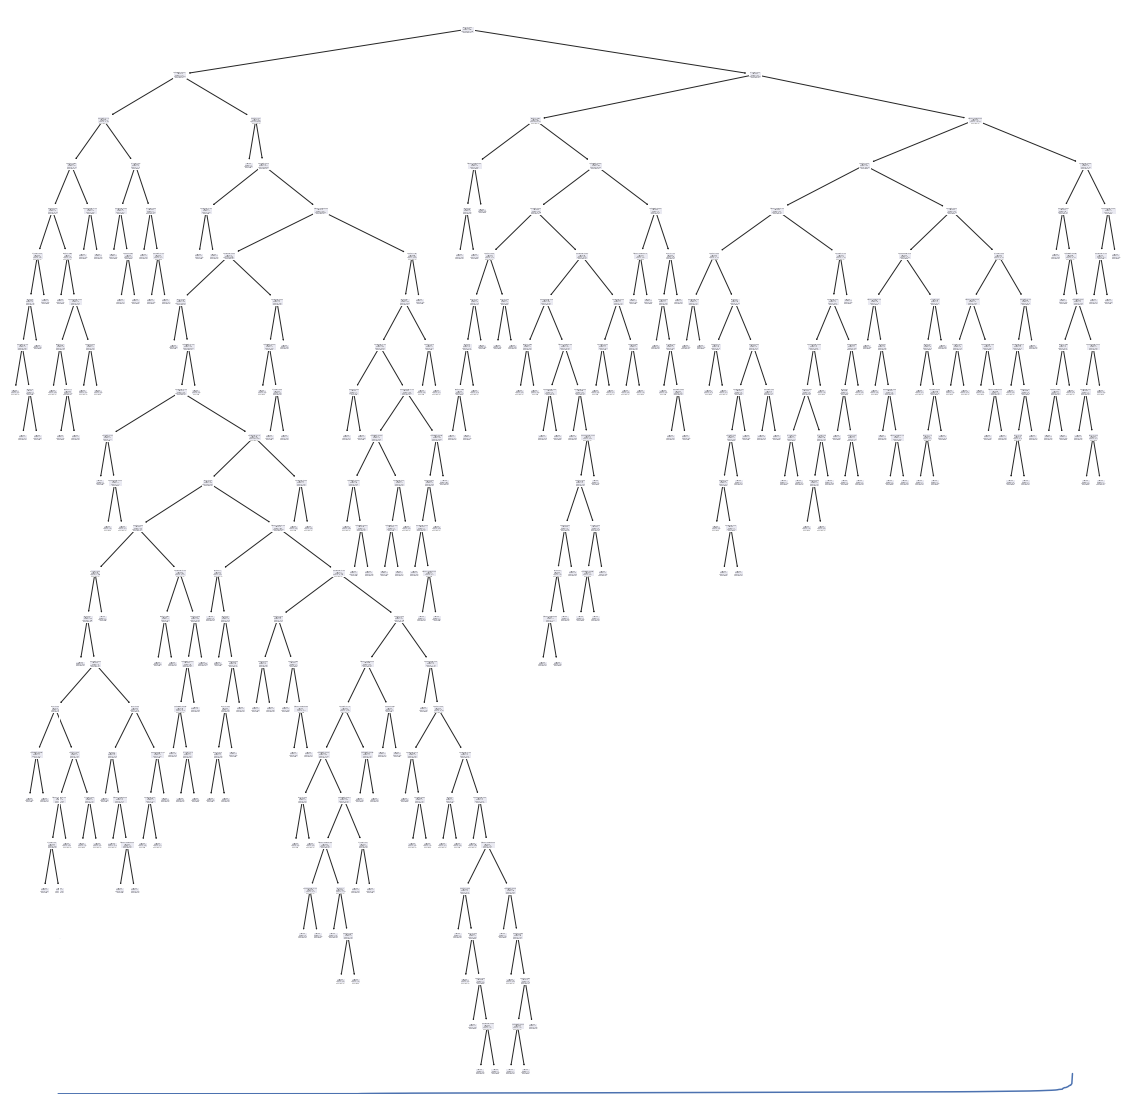

In [162]:
#VINHO TINTO

'''
dataset, header = loadFile("./winequality-red.csv")
header[11] = header[11].strip('\n')
redMissing = removeValues(dataset, 0.1)
redMissing = handleMissingValues(redMissing, 'mean')
#redMissing = handleMissingValues(redMissing, 'most_frequent')

red1 = applyNormalization(dataset, 'l1')
print(red1)
red2 = applyNormalization(dataset, 'l2')
print(red2)
red3 = applyNormalization(dataset, 'max')
print(red3)

redRed = applyDataReduction(dataset)

redDisc = applyDiscretization(dataset)

df = pd.DataFrame(dataset, columns = header)
df["wine classification"] =  ["good" if i >= 7 else ("bad" if i < 5 else "medium") for i in df['quality']]

X = df.drop("wine classification", axis=1)
X = X.drop("quality", axis=1)

df = pd.DataFrame(redMissing, columns = header)
df["wine classification"] =  ["good" if i >= 7 else ("bad" if i < 5 else "medium") for i in df['quality']]

X1 = df.drop("wine classification", axis=1)
X1 = X1.drop("quality", axis=1)
'''
#plotAllPearson(dataset, header)

#sns_visualization = sns.pairplot(df)

#decisionTree(df, X, "wine classification")

#ourMLPClassifier(df, X, "wine classification")

#knn(df, X, "wine classification")

#kMeans(df, X, "wine classification", header)

#dbscan(df, X, "wine classification")

agglomerativeClustering(df, X, "wine classification")


#visualizePairOfFeatures(df, "fixed acidity", "citric acid")
#visualizePairOfFeatures(df, "fixed acidity", "density")
#visualizePairOfFeatures(df, "free sulfur dioxide", "total sulfur dioxide")

#barPlotWineQuality(df)


# (fixed acidity, citric acid) (density, fixed acidity) (total sulfur dioxide, free sulfur dioxide)
# (quality, alcohol)




4898 0.1 1


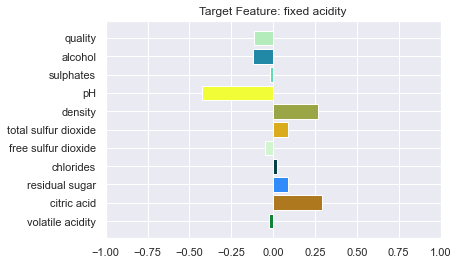

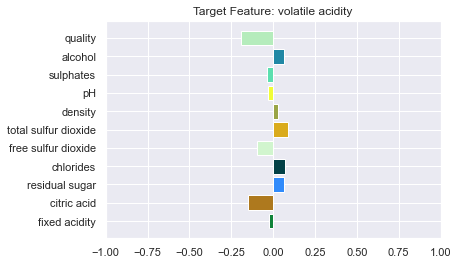

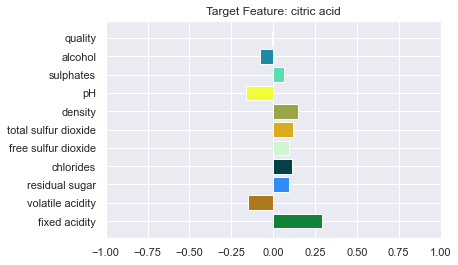

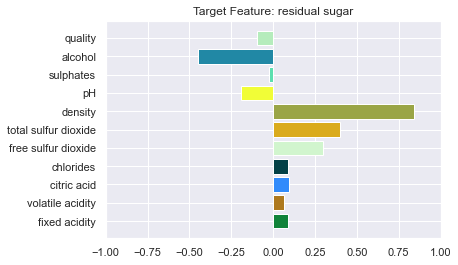

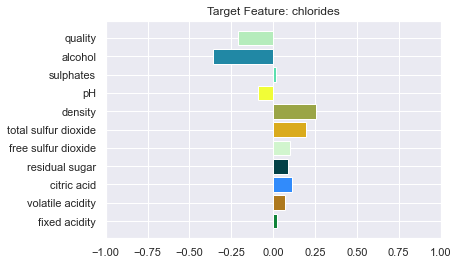

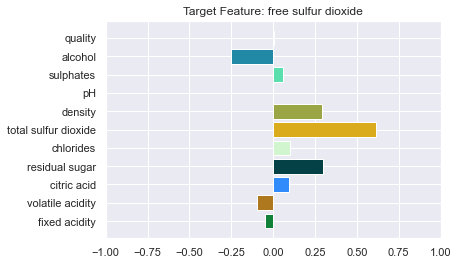

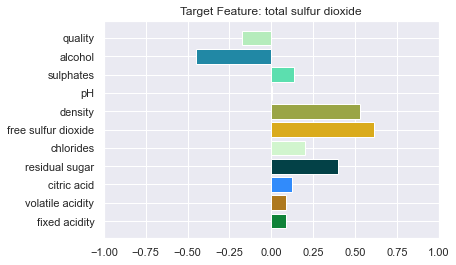

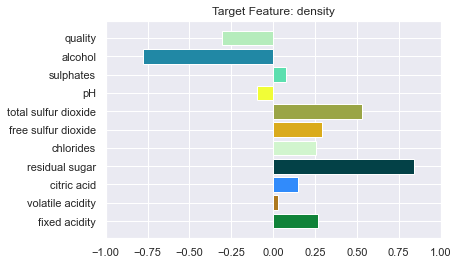

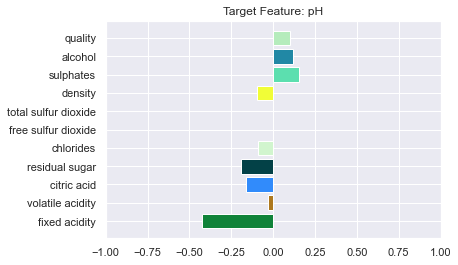

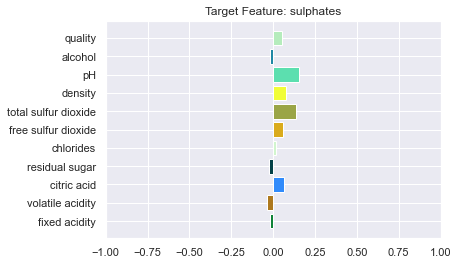

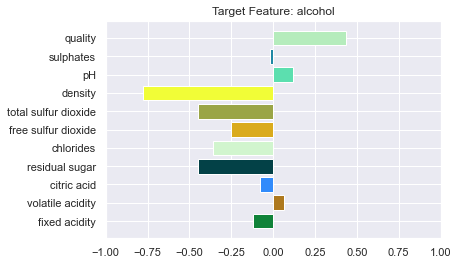

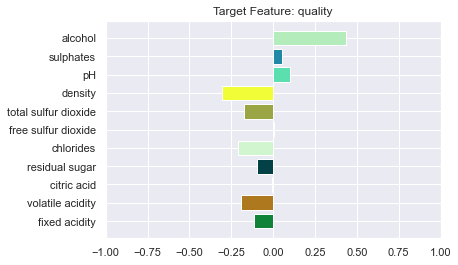

['medium' 'medium' 'medium' ... 'medium' 'medium' 'medium']
Accuracy: 0.7485714285714286
0.41037304389438795


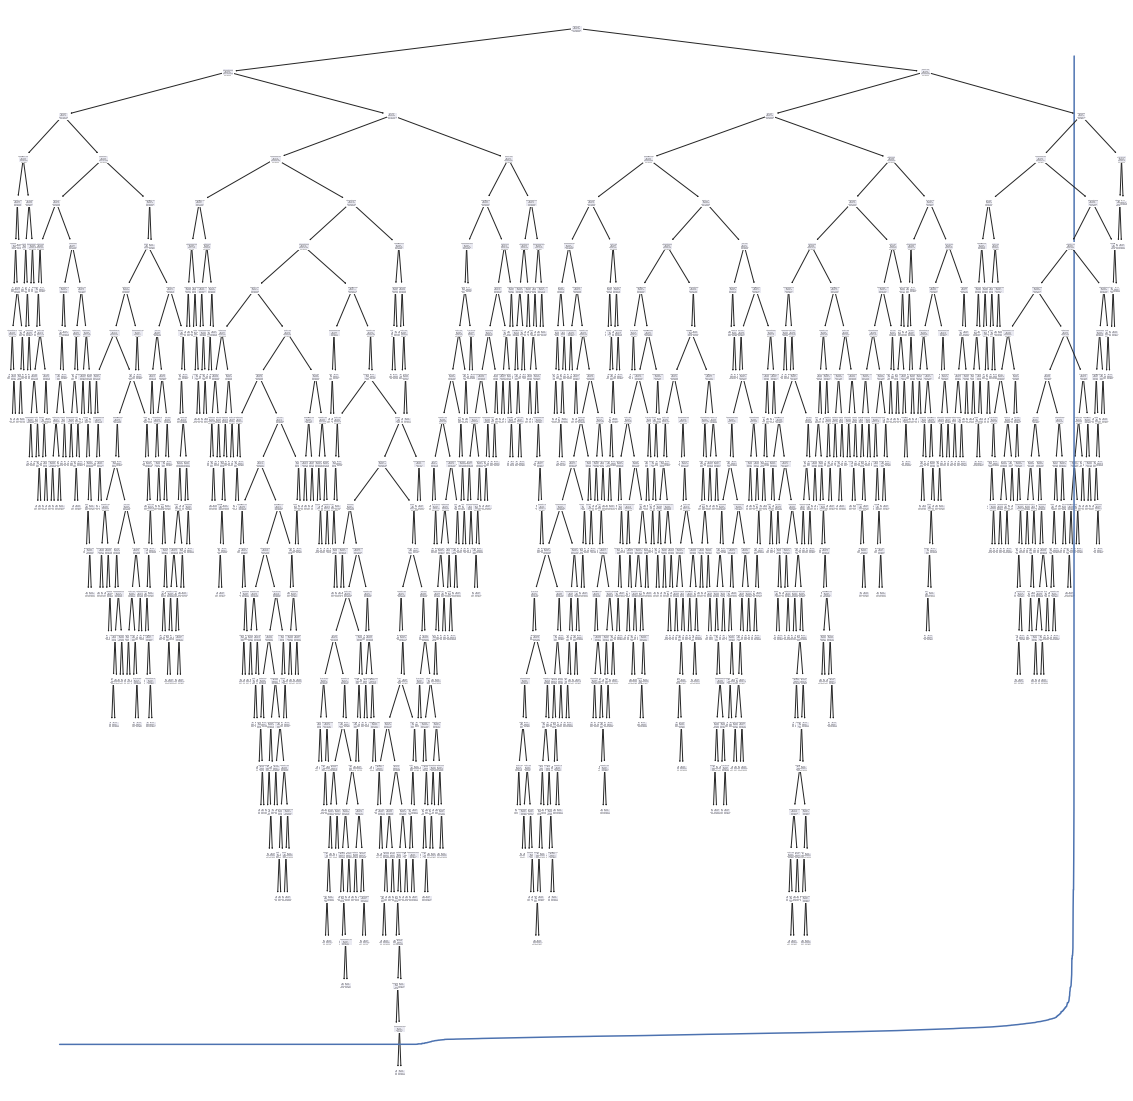

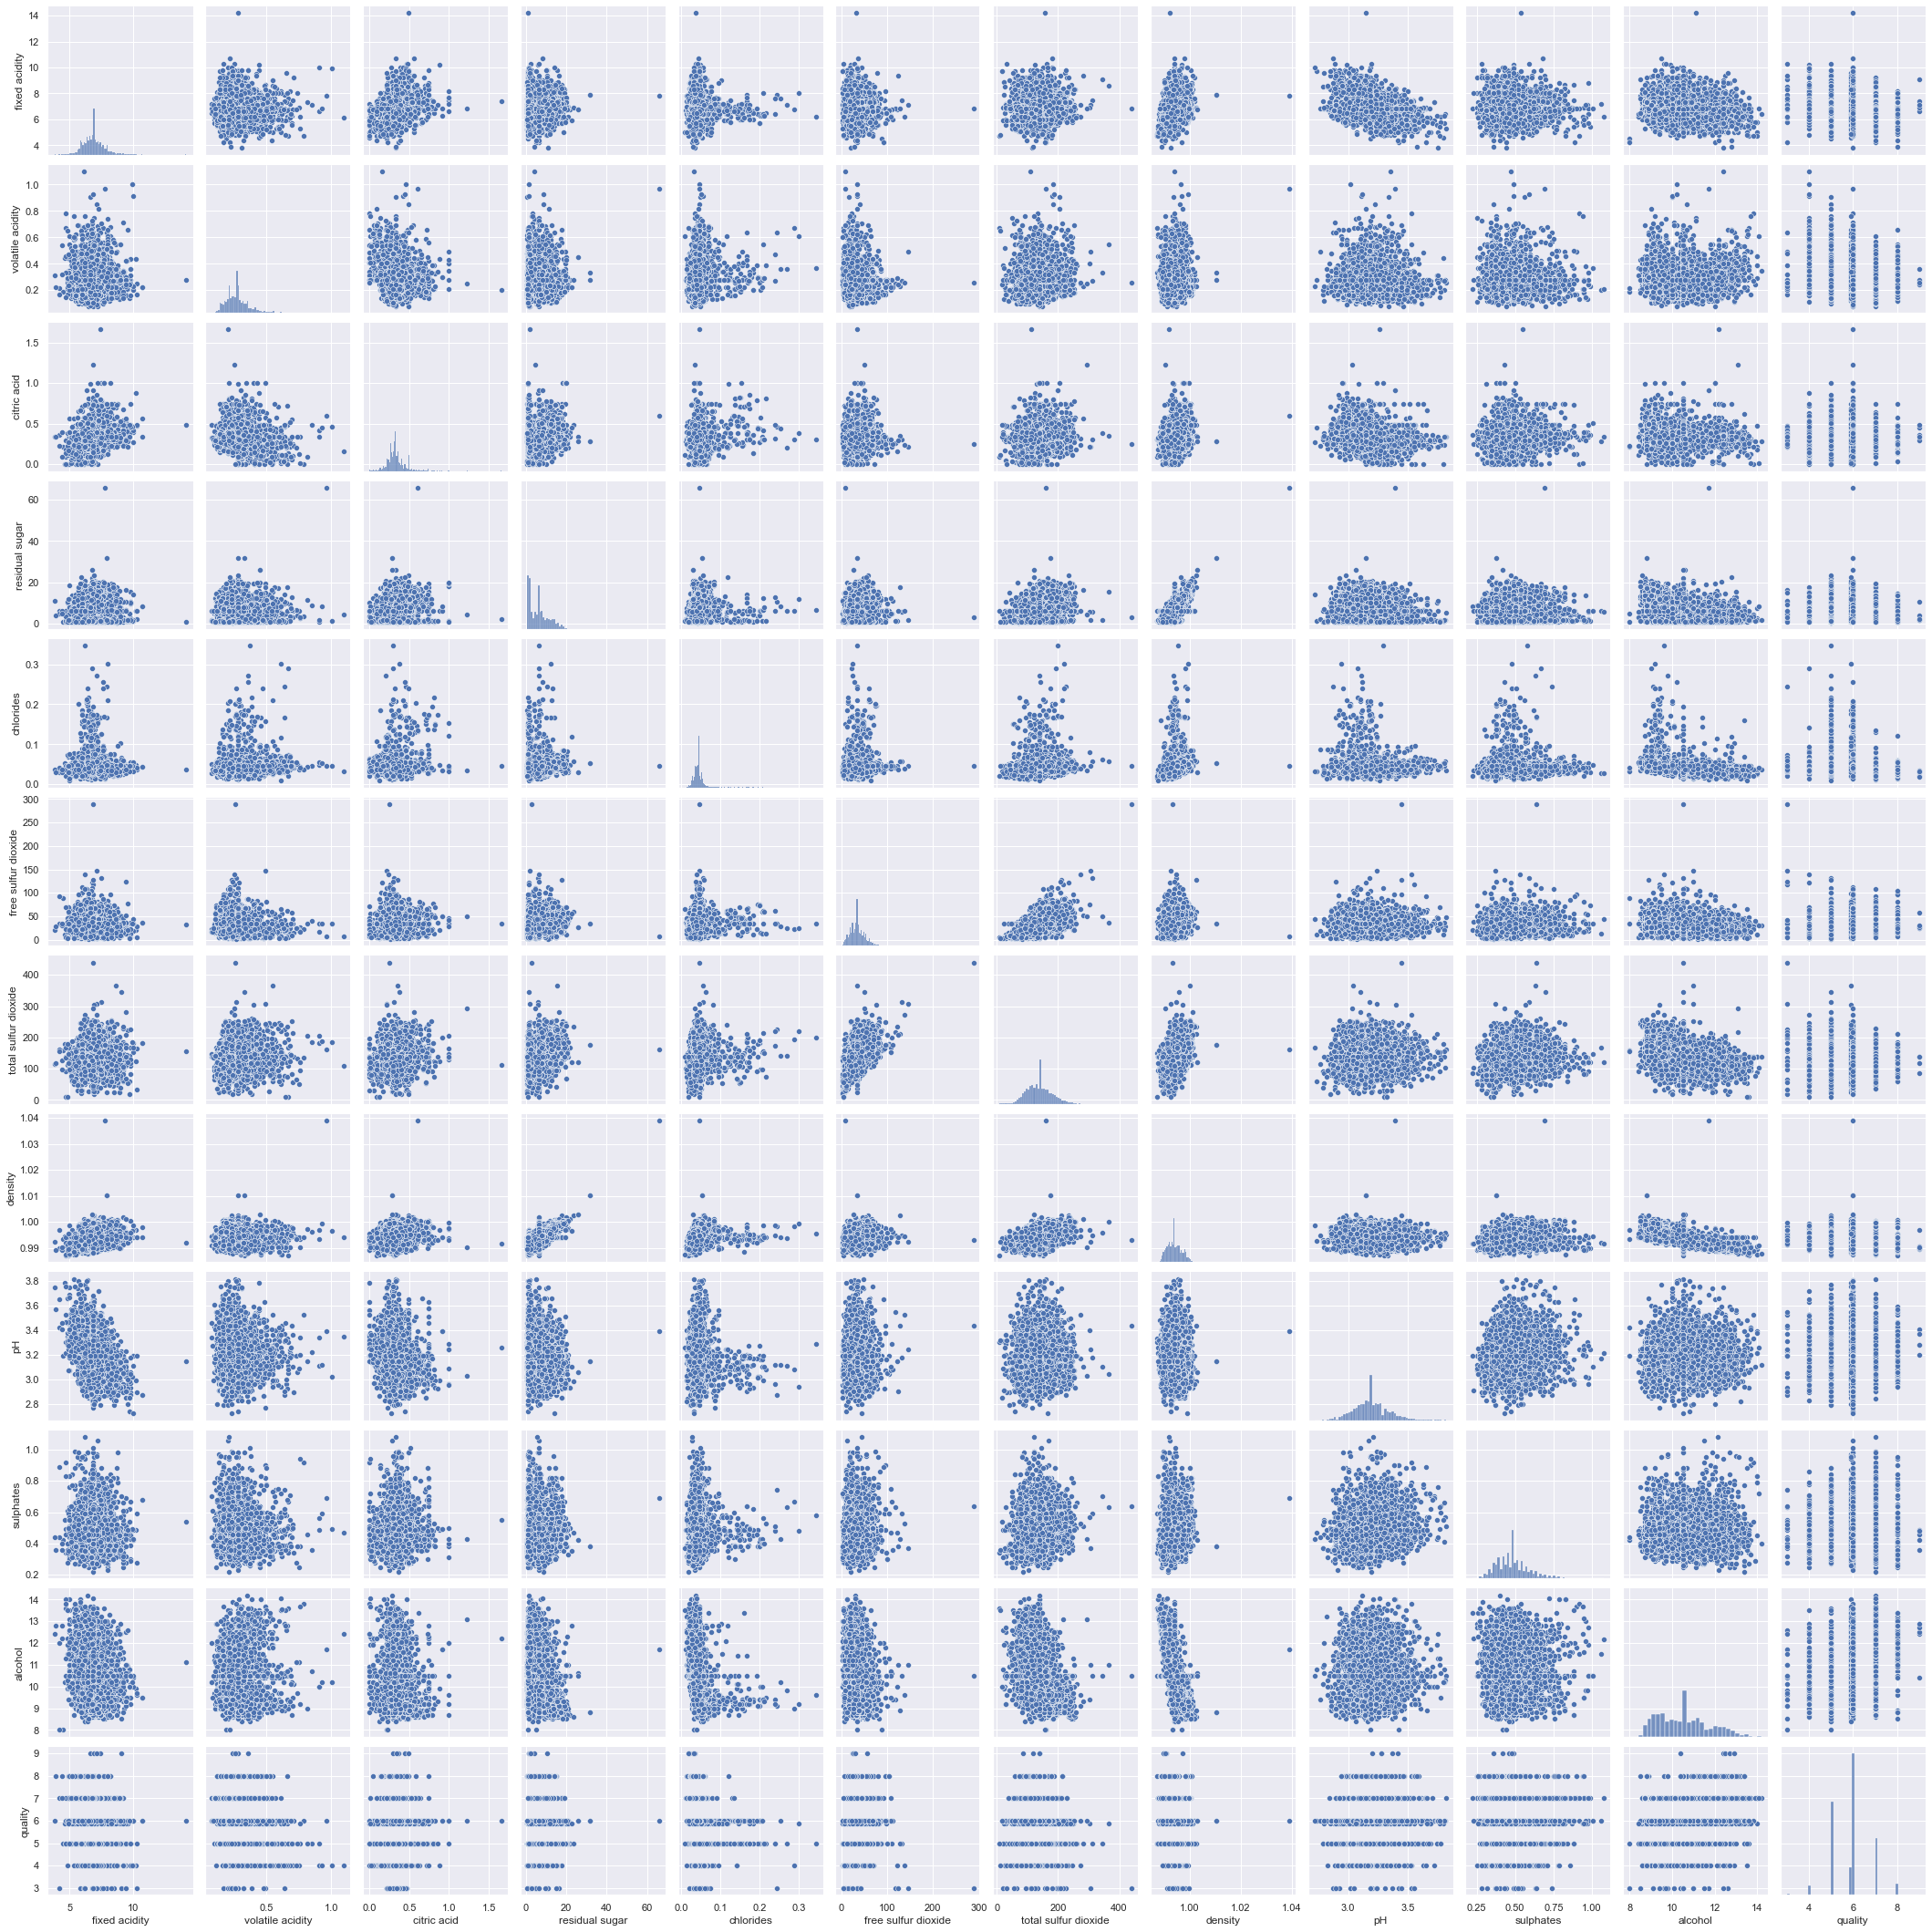

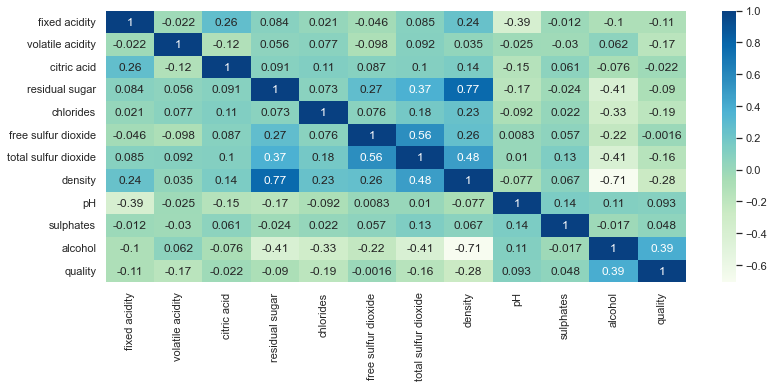

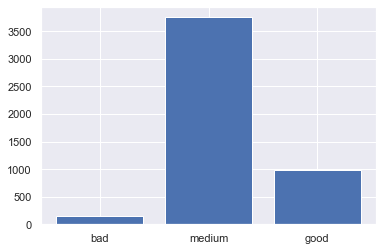

In [73]:
#VINHO BRANCO

dataset, header = loadFile("./winequality-white.csv")
header[11] = header[11].strip('\n')
redMissing = removeValues(dataset, 0.1)
redMissing = handleMissingValues(redMissing, 'mean')
#redMissing = handleMissingValues(redMissing, 'most_frequent')

'''
red1 = applyNormalization(dataset, 'l1')
print(red1)
red2 = applyNormalization(dataset, 'l2')
print(red2)
red3 = applyNormalization(dataset, 'max')
print(red3)

redRed = applyDataReduction(dataset)

redDisc = applyDiscretization(dataset)
'''
df = pd.DataFrame(dataset, columns = header)
df["wine classification"] =  ["good" if i >= 7 else ("bad" if i < 5 else "medium") for i in df['quality']]

X = df.drop("wine classification", axis=1)
X = X.drop("quality", axis=1)

df = pd.DataFrame(redMissing, columns = header)
df["wine classification"] =  ["good" if i >= 7 else ("bad" if i < 5 else "medium") for i in df['quality']]

X1 = df.drop("wine classification", axis=1)
X1 = X1.drop("quality", axis=1)

plotAllPearson(dataset, header)

decisionTree(df, X, "wine classification")

ourMLPClassifier(df, X, "wine classification")

knn(df, X, "wine classification")

kMeans(df, X, "wine classification", header)

dbscan(df, X, "wine classification")

agglomerativeClustering(df, X, "wine classification")

#print(ourMLPClassifier(df, X, "wine classification"))

#print(ourMLPClassifier(df, X1, "wine classification"))

sns_visualization = sns.pairplot(df)


#print(pearsonCorrelation(dataset, header, "fixed acidity"))

correlationMatrix(df)

#visualizePairOfFeatures(df, "fixed acidity", "citric acid")
#visualizePairOfFeatures(df, "fixed acidity", "density")
#visualizePairOfFeatures(df, "free sulfur dioxide", "total sulfur dioxide")

barPlotWineQuality(df)


# (fixed acidity, citric acid) (density, fixed acidity) (total sulfur dioxide, free sulfur dioxide)
# (quality, alcohol)


